# Imports 📥

In [6]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,RandomFlip, RandomRotation, RandomZoom
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Creating directories for free spoken digit dataset (fsdd) 🗂️

In [3]:
dataset_drive_path = "./SpeechDataset"
os.makedirs(dataset_drive_path, exist_ok=True)

In [ ]:
import urllib.request
import zipfile

fsdd_url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip"
zip_path = os.path.join(dataset_drive_path, "fsdd.zip")

# Download dataset only if it doesn't exist
if not os.path.exists(zip_path):
    print("Downloading FSDD dataset...")
    urllib.request.urlretrieve(fsdd_url, zip_path)

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_drive_path)

print(f"Dataset saved to {dataset_drive_path} !")

Dataset saved to Google Drive!


## Ensuring that dataset is saved successfully

In [3]:
audio_folder = os.path.join(dataset_drive_path, "free-spoken-digit-dataset-master/recordings")

In [4]:
# List all audio files in the dataset folder
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

# Select one file (for example, the first one)
audio_path = os.path.join(audio_folder, audio_files[9])
print(f"Playing audio: {audio_path}")

# Load and play audio
y, sr = librosa.load(audio_path, sr=None)  # Load with original sample rate
ipd.Audio(y, rate=sr)


Playing audio: ./SpeechDataset/free-spoken-digit-dataset-master/recordings/0_theo_13.wav


# Splitting dataset to train dev and test ✂️

- 80% for train 10% for valdiation and 10% for test
- 2400 images for train 300 image for validation and 10% for test

In [10]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# Set dataset path (update this if needed)
dataset_path = "./SpeechDataset/free-spoken-digit-dataset-master/recordings"

# Get all audio files
audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Sort for consistency
audio_files.sort()

# Create output directories
output_base = "./SpeechDataset/split_data"
train_dir = os.path.join(output_base, "train")
dev_dir = os.path.join(output_base, "dev")
test_dir = os.path.join(output_base, "test")

for folder in [train_dir, dev_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Split data: 80% Train, 10% Dev, 10% Test
train_files, temp_files = train_test_split(audio_files, test_size=0.2, random_state=42)
dev_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to move files
def move_files(file_list, src_folder, dest_folder):
    for file in file_list:
        shutil.copy(os.path.join(src_folder, file), os.path.join(dest_folder, file))

# Move files to respective folders
move_files(train_files, dataset_path, train_dir)
move_files(dev_files, dataset_path, dev_dir)
move_files(test_files, dataset_path, test_dir)

print(f"✅ Data split completed!")
print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(dev_files)}")
print(f"Test files: {len(test_files)}")


✅ Data split completed!
Training files: 2400
Validation files: 300
Test files: 300


# Applying data augmentation 🧬

## Applying data augmentation to voice recordings 🔊

In [24]:
import librosa
import numpy as np
import os
import soundfile as sf
import glob
import random

# Paths
input_folder = "./SpeechDataset/split_data/train/"  # Folder containing original recordings
output_folder = "./SpeechDataset/split_data/augmented_train_noise"  # Folder to save augmented files
os.makedirs(output_folder, exist_ok=True)  # Create output folder if not exists

# Function to add noise
def add_noise(audio, noise_level=0.001):
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

# Function to apply a random augmentation
def augment_audio(file_path, output_folder, file_index):
    y, sr = librosa.load(file_path, sr=None)
    # Add noise to original audio
    y_noisy = add_noise(y)
    # Randomly choose between speed up or slow down
    # if random.choice([True, False]):  
    #     y_aug = librosa.effects.time_stretch(y_noisy, rate=1.05)  # Speed up
    # else:
    #     y_aug = librosa.effects.time_stretch(y_noisy, rate=0.95)  # Slow down
    # Extract filename without extension
    base_name, ext = os.path.splitext(os.path.basename(file_path))
    # Save augmented audio
    output_path = os.path.join(output_folder, f"{base_name}_aug{ext}")
    # Save augmented audio
    sf.write(output_path, y_noisy, sr)

# Process all audio files
audio_files = glob.glob(os.path.join(input_folder, "*.wav"))  # Get all .wav files
for idx, file_path in enumerate(audio_files):
    augment_audio(file_path, output_folder, idx)

print(f"✅ Data augmentation complete! Augmented samples saved in '{output_folder}'")
# Count the number of augmented samples
augmented_files = glob.glob(os.path.join(output_folder, "*.wav"))
print(f"🔢 Total number of augmented samples: {len(augmented_files)}")


✅ Data augmentation complete! Augmented samples saved in './SpeechDataset/split_data/augmented_train_noise'
🔢 Total number of augmented samples: 2400


## Applying data augmentation to spectrograms 🖼️

In [10]:
import tensorflow as tf
import os
import numpy as np
import cv2

# Define dataset path
dataset_path = "./SpeechDataset/spectrograms_clean_aug"
augmented_path = "./SpeechDataset/augmented_spectrograms"

# Ensure the augmented dataset directory exists
os.makedirs(augmented_path, exist_ok=True)

# Define image size
img_size = (224, 224)

# Augmentation functions
def random_stretch_squeeze(image):
    """ Randomly stretches or squeezes the image horizontally. """
    scale = np.random.uniform(0.8, 1.2)  # Random width scaling (80% to 120%)
    new_width = int(img_size[1] * scale)
    image = cv2.resize(image, (new_width, img_size[0]))
    return cv2.resize(image, img_size)  # Resize back to original size

def add_noise(image):
    """ Adds Gaussian noise to the image. """
    noise = np.random.normal(0, 0.05, image.shape) * 255
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

# Process and save augmented images
for split in ["train", "dev", "test"]:
    input_dir = os.path.join(dataset_path, split)
    output_dir = os.path.join(augmented_path, split)
    os.makedirs(output_dir, exist_ok=True)

    for label in os.listdir(input_dir):  # Loop through classes (0, 1, 2, ...)
        label_dir = os.path.join(input_dir, label)
        save_label_dir = os.path.join(output_dir, label)
        os.makedirs(save_label_dir, exist_ok=True)

        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue  # Skip unreadable files

            image = cv2.resize(image, img_size)  # Ensure consistency

            # Save original
            cv2.imwrite(os.path.join(save_label_dir, img_name), image)
            if split == "train":
                # Create augmented version
                aug_image = random_stretch_squeeze(image)  # Stretch/squeeze
                aug_image = add_noise(aug_image)  # Add noise

                # Save augmented image
                aug_img_name = f"aug_{img_name}"
                cv2.imwrite(os.path.join(save_label_dir, aug_img_name), aug_image)

print("✅ Augmented spectrograms saved successfully!")


✅ Augmented spectrograms saved successfully!


# Generating log-magnitude spectrogram generated from the Short-Time Fourier Transform (STFT) 🔊→🖼️

In [25]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Define dataset paths
base_path = "./SpeechDataset/split_data"
output_base = "./SpeechDataset/spectrograms_clean_noise_aug"

# Define subdirectories for train, dev, and test sets
#datasets = ["train", "dev", "test"]
datasets = ["augmented_train_noise"]

# Create output directories for spectrograms
for dataset in datasets:
    os.makedirs(os.path.join(output_base, dataset), exist_ok=True)

# Function to generate and save spectrograms
def generate_spectrogram(audio_path, output_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y,n_fft=1024)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log", cmap="viridis")
    plt.colorbar(label="Magnitude (dB)")
    plt.title(f"Spectrogram of {os.path.basename(audio_path)}")
    plt.tight_layout()

    # Save spectrogram
    plt.savefig(output_path, dpi=300)
    plt.close()

# Function to generate and save a clean spectrogram
def generate_spectrogram_clean(audio_path, output_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=1024)), ref=np.max)

    # Plot spectrogram without axis labels or colorbar
    fig, ax = plt.subplots(figsize=(5, 5))
    librosa.display.specshow(D, sr=sr, cmap="viridis", ax=ax)

    # Remove titles, ticks, and axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    # Save spectrogram
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

# Generate spectrograms for train, dev, and test sets
for dataset in datasets:
    dataset_path = os.path.join(base_path, dataset)
    output_path = os.path.join(output_base, dataset)

    print(f"📂 Processing {dataset} set...")
    # Process each file with a progress bar
    files = [file for file in os.listdir(dataset_path) if file.endswith(".wav")]
    for file in tqdm(files, desc="Generating Spectrograms", unit="file"):
        if file.endswith(".wav"):
            audio_path = os.path.join(dataset_path, file)
            spectrogram_path = os.path.join(output_path, f"{os.path.splitext(file)[0]}.png")
            generate_spectrogram_clean(audio_path, spectrogram_path)

    print(f"✅ Spectrograms saved in {output_path}!")

print("\n🎯 **All Spectrograms Generated Successfully!**")


📂 Processing augmented_train_noise set...


Generating Spectrograms: 100%|██████████| 2400/2400 [03:50<00:00, 10.41file/s]

✅ Spectrograms saved in ./SpeechDataset/spectrograms_clean_noise_aug/augmented_train_noise!

🎯 **All Spectrograms Generated Successfully!**


## Visualizing a random sample from the generated spectrograms 🖥️

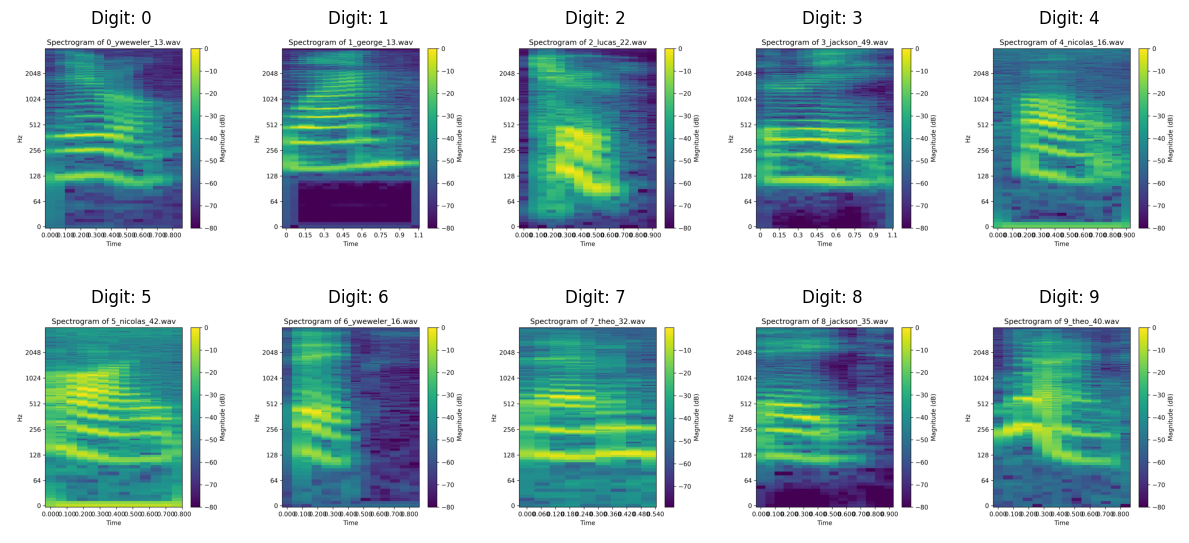

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the dataset containing digit folders
dataset_path = "./SpeechDataset/spectrograms/train"

# Get all digit class folders 
digit_classes = sorted(os.listdir(dataset_path))

# Initialize a figure for displaying images
plt.figure(figsize=(12, 6))

# Loop through each digit class and display one random image
for i, digit in enumerate(digit_classes):
    digit_folder = os.path.join(dataset_path, digit)
    
    # Get all spectrogram images inside the digit folder
    image_files = [f for f in os.listdir(digit_folder) if f.endswith('.png')]
    
    if image_files:  # Ensure there are images in the folder
        chosen_image = random.choice(image_files)  # Pick a random image
        img_path = os.path.join(digit_folder, chosen_image)

        # Load and display the image
        img = mpimg.imread(img_path)
        plt.subplot(2, 5, i + 1)  # Create a 2-row, 5-column grid
        plt.imshow(img, cmap="gray")
        plt.title(f"Digit: {digit}")
        plt.axis("off")  # Hide axes

# Show all images
plt.tight_layout()
plt.show()

# Labelling the data 🏷️


*   we are creating sub-directories that their name will be used later as the image label (supervised learning)

*   each image in folder 0 means that it is the spectrogram of the digit 0
*   first we will create directories then move the image to the corresponding directory according to the title of the image



In [26]:
import os
import shutil

# Base dataset path
dataset_path = "./SpeechDataset/spectrograms_clean_noise_aug/"

# Ensure all splits are processed
splits = ["train", "dev", "test"]


for split in splits:
    split_path = os.path.join(dataset_path, split)

    # Check if split folder exists
    if not os.path.exists(split_path):
        print(f"❌ Warning: {split_path} not found, skipping...")
        continue

    print(f"📂 Processing: {split_path}")

    # Process each file
    for file in os.listdir(split_path):
        if file.endswith(".png"):  # Only process spectrogram images
            digit_label = file.split("_")[0]  # Extract digit (e.g., "3" from "3_george.png")

            # Ensure the label is a digit (0-9)
            if digit_label.isdigit():
                digit_folder = os.path.join(split_path, digit_label)

                # Create subfolder if it doesn’t exist
                os.makedirs(digit_folder, exist_ok=True)

                # Move file to corresponding digit folder
                shutil.move(os.path.join(split_path, file), os.path.join(digit_folder, file))
                print(f"✅ Moved {file} → {digit_folder}/")
            else:
                print(f"⚠️ Skipping file: {file} (Invalid label: {digit_label})")

print("🎉 Done! All spectrograms are now organized into subfolders.")


📂 Processing: ./SpeechDataset/spectrograms_clean_noise_aug/train
✅ Moved 6_yweweler_17_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/6/
✅ Moved 4_george_1_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/4/
✅ Moved 5_george_19_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/5/
✅ Moved 5_yweweler_17_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/5/
✅ Moved 4_theo_26_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/4/
✅ Moved 0_yweweler_48_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/0/
✅ Moved 2_george_47_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/2/
✅ Moved 0_lucas_48_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/0/
✅ Moved 3_nicolas_41_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/3/
✅ Moved 6_theo_39_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/6/
✅ Moved 0_nicolas_35_aug.png → ./SpeechDataset/spectrograms_clean_noise_aug/train/0/
✅ Moved 4

# Preprocessing the dataset 📊

In [11]:
import tensorflow as tf
import os

# Define dataset path
dataset_path = "./SpeechDataset/augmented_spectrograms/"

# Load dataset
batch_size = 32
img_size = (224, 224)  # Resize to match ResNet input size

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"  # Labels are inferred from folder names
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, "dev"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, "test"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"
)

Found 9600 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


# Creating the Model (MobileNet)
loading the tensorflow mobilenet architecture and loading the pretrained weights and creating custom classification layers in the end.

In [12]:
# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the top layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom classification layers for (10 classes)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)  # Multi-class classification (10 classes)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,534,858 (13.48 MB)

 Trainable params: 2,700,746 (10.30 MB)

 Non-trainable params: 834,112 (3.18 MB)

## Training the model 🏋️

In [ ]:
# Train the model with a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, patience=3,
    min_lr=1e-6
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                 # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore the model from the best epoch
    verbose=1
)

# Train for more epochs (with data augmentation)
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.2428 - loss: 2.5836 - val_accuracy: 0.6367 - val_loss: 1.0627 - learning_rate: 0.0010
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7041 - loss: 0.8411 - val_accuracy: 0.8867 - val_loss: 0.3524 - learning_rate: 0.0010
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8490 - loss: 0.4878 - val_accuracy: 0.9100 - val_loss: 0.2666 - learning_rate: 0.0010
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9093 - loss: 0.3059 - val_accuracy: 0.8733 - val_loss: 0.3596 - learning_rate: 0.0010
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9246 - loss: 0.2649 - val_accuracy: 0.9467 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9440 - loss: 0.2040 - val_accuracy: 0.9567 - val_loss: 0.1139 - learning_rate: 0.0010
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9516 - l

## Evaluating the model on the test dataset 📝

In [14]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9745 - loss: 0.0806 
Test Accuracy: 0.9700


## Saving the model 💾

In [25]:
model.save("./model_clean.h5")